# Week 01 - Lesson 04 - Building Custom AI Agent Workflows with LangGraph

## Overview

This notebook teaches you how to create custom AI agent workflows using LangGraph. You'll learn to build intelligent agents that can make decisions, execute tools, and orchestrate complex business processes.

### Learning Objectives
1. Understand LangGraph's core concepts and architecture
2. Create custom agent workflows from scratch
3. Integrate tools and external functions into workflows
4. Build decision-making agents with conditional logic
5. Understand workflow orchestration patterns
6. Extend and customize agent capabilities

## Why LangGraph?

# <img src="https://www.qodo.ai/wp-content/uploads/2025/03/Building-Agentic-Flows-with-LangGraph.png" alt="Building Agentic Flows with LangGraph" style="width: 90%; height: 400px; object-fit: cover; display: block; margin-bottom: 1em;">

LangGraph is designed for building **stateful, multi-actor applications** with LLMs. Unlike simple chains, LangGraph allows you to:
- **Maintain state** across multiple interactions
- **Make decisions** about what to do next
- **Coordinate multiple tools** and functions
- **Handle complex workflows** with loops and conditions
- **Build enterprise-grade** AI applications

## Key Concepts

1. **StateGraph**: The main class for building workflows
2. **Nodes**: Functions that process data and make decisions
3. **Edges**: Connections that define workflow flow
4. **State**: Data that flows through your workflow
5. **Tools**: External functions your agent can call

## 1. Environment Setup and Dependencies

First, let's ensure we have all necessary dependencies installed and configured.

In [1]:
# Install required dependencies
%pip install -U --quiet langchain langchain-openai langgraph

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from typing import Literal

In [3]:
print("\nKey imports explained:")
print("  - ToolNode: Pre-built node for executing tools")
print("  - StateGraph: Main class for building workflows")
print("  - MessagesState: State schema for message-based workflows")
print("  - START/END: Special nodes for workflow entry and exit")


Key imports explained:
  - ToolNode: Pre-built node for executing tools
  - StateGraph: Main class for building workflows
  - MessagesState: State schema for message-based workflows
  - START/END: Special nodes for workflow entry and exit


## 2. Setting Up the Foundation

Let's start by setting up the core components: the language model and our custom tools.

In [ ]:
# Your OpenAI API Key here
OPENAI_API_KEY = "sk-your-openai-api-key"

In [5]:
# Initialize the Chat Model
llm = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=OPENAI_API_KEY,
    temperature=0.1  # Low temperature for consistent, predictable responses
)

print("✅ Language Model initialized successfully!")
print(f"Model: {llm.model_name}")
print(f"Temperature: {llm.temperature}")

✅ Language Model initialized successfully!
Model: gpt-4o-mini
Temperature: 0.1


## 3. Creating Custom Tools

`Tools` are the "hands" of your agent - they allow it to interact with external systems, databases, and APIs. Let's create some tools with mocked data.

> **We will talk more about Tools at Week 02 but for now you just need to understand that tools are the external functions your agent can call to perform actions, like retrieving data from databases, calling APIs, or executing business logic. For this lesson, we'll focus on building the workflow structure and basic tool integration to demonstrate how agents make decisions about when and how to use these capabilities.**

In [6]:
# Create custom tools
# These tools simulate real business operations that your agent can perform
# We will talk about this in more detail at Week 02

@tool
def get_customer_info(customer_id: str) -> str:
    """
    Retrieve customer information from CRM system.
    
    Args:
        customer_id (str): The customer ID (e.g., CUST-001)
        
    Returns:
        str: Customer information including name, tier, and spending
        
    Example:
        get_customer_info("CUST-001") -> Returns customer details
    """
    # Mock CRM database - in production, this would call your actual CRM API
    customer_database = {
        "CUST-001": {
            "name": "John Smith", 
            "tier": "Premium", 
            "spend": "$2,500",
            "last_purchase": "2024-01-15",
            "email": "john.smith@email.com"
        },
        "CUST-002": {
            "name": "Sarah Johnson", 
            "tier": "Standard", 
            "spend": "$800",
            "last_purchase": "2024-01-10",
            "email": "sarah.j@email.com"
        },
        "CUST-003": {
            "name": "Mike Davis", 
            "tier": "Premium", 
            "spend": "$3,200",
            "last_purchase": "2024-01-20",
            "email": "mike.davis@email.com"
        }
    }
    
    if customer_id in customer_database:
        customer = customer_database[customer_id]
        return f"Customer {customer_id}: {customer['name']}, {customer['tier']} tier, total spend: {customer['spend']}, last purchase: {customer['last_purchase']}"
    
    return f"Customer {customer_id} not found in the system."

@tool
def get_sales_forecast(region: str, period: str = "Q1 2024") -> str:
    """
    Get sales forecast from business intelligence system.
    
    Args:
        region (str): Geographic region (North, South, East, West)
        period (str): Time period for forecast (default: Q1 2024)
        
    Returns:
        str: Sales forecast data for the specified region and period
        
    Example:
        get_sales_forecast("North", "Q2 2024") -> Returns forecast data
    """
    # Mock BI system - in production, this would call your actual business intelligence platform
    forecast_database = {
        "North": {
            "Q1 2024": "$1.2M", 
            "Q2 2024": "$1.5M", 
            "Q3 2024": "$1.8M",
            "Q4 2024": "$2.1M"
        },
        "South": {
            "Q1 2024": "$800K", 
            "Q2 2024": "$950K", 
            "Q3 2024": "$1.1M",
            "Q4 2024": "$1.3M"
        },
        "East": {
            "Q1 2024": "$1.1M", 
            "Q2 2024": "$1.3M", 
            "Q3 2024": "$1.6M",
            "Q4 2024": "$1.9M"
        },
        "West": {
            "Q1 2024": "$900K", 
            "Q2 2024": "$1.1M", 
            "Q3 2024": "$1.3M",
            "Q4 2024": "$1.6M"
        }
    }
    
    if region in forecast_database and period in forecast_database[region]:
        forecast = forecast_database[region][period]
        return f"Sales forecast for {region} region in {period}: {forecast}"
    
    return f"Forecast data not available for {region} region in {period}. Available periods: {list(forecast_database.get(region, {}).keys())}"

@tool
def create_support_ticket(customer_id: str, issue_description: str, priority: str = "Medium") -> str:
    """
    Create a support ticket in the ticketing system.
    
    Args:
        customer_id (str): The customer ID for the ticket
        issue_description (str): Description of the issue or request
        priority (str): Ticket priority (Low, Medium, High, Critical)
        
    Returns:
        str: Confirmation with ticket ID and details
        
    Example:
        create_support_ticket("CUST-001", "Payment failed", "High") -> Creates ticket
    """
    # Mock ticketing system - in production, this would create a real ticket in your system
    import hashlib
    import datetime
    
    # Generate a unique ticket ID
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    hash_input = f"{customer_id}{issue_description}{timestamp}"
    ticket_hash = hashlib.md5(hash_input.encode()).hexdigest()[:8]
    ticket_id = f"TKT-{customer_id}-{ticket_hash}"
    
    # Simulate ticket creation
    ticket_data = {
        "ticket_id": ticket_id,
        "customer_id": customer_id,
        "issue": issue_description,
        "priority": priority,
        "status": "Open",
        "created_at": datetime.datetime.now().isoformat(),
        "assigned_to": "Support Team"
    }
    
    return f"Support ticket {ticket_id} created successfully!\nCustomer: {customer_id}\nIssue: {issue_description}\nPriority: {priority}\nStatus: Open\nAssigned to: Support Team"

print("✅ Custom Tools Created Successfully!")
print("\n🧰 Available Tools:")
print(f"1. get_customer_info: Retrieve customer data from CRM system")
print(f"2. get_sales_forecast: Get sales projections by region and period")
print(f"3. create_support_ticket: Create support tickets in ticketing system")

✅ Custom Tools Created Successfully!

🧰 Available Tools:
1. get_customer_info: Retrieve customer data from CRM system
2. get_sales_forecast: Get sales projections by region and period
3. create_support_ticket: Create support tickets in ticketing system


## 4. Understanding the Workflow Architecture

Before we build our agent, let's understand LangGraph workflows can be structured:

```
START → LLM Node → Decision Point → Tools Node (if needed) → LLM Node → END
```

### How It Works:
1. **START**: Workflow begins
2. **LLM Node**: Processes user input and decides what to do
3. **Decision Point**: Determines if tools are needed
4. **Tools Node**: Executes tools if required
5. **LLM Node**: Processes tool results and provides final response
6. **END**: Workflow completes

In [7]:
# Create tool node with available tools
# ToolNode is a pre-built LangGraph node that handles tool execution
tools = [get_customer_info, get_sales_forecast, create_support_ticket]
tool_node = ToolNode(tools)

# Bind tools to LLM so it knows what tools are available
# This is crucial - the LLM needs to understand what tools it can use
llm_with_tools = llm.bind_tools(tools)

print("✅ Tool Integration Complete!")

✅ Tool Integration Complete!


In [8]:
print(f"\n🧰 Tools Available: {len(tools)}")

print("\n🤔 What Happened:")
print("  - ToolNode created: Handles execution of all tools")
print("  - LLM bound to tools: Now knows what tools are available")
print("  - Ready for workflow: Tools can now be called by the agent")


🧰 Tools Available: 3

🤔 What Happened:
  - ToolNode created: Handles execution of all tools
  - LLM bound to tools: Now knows what tools are available
  - Ready for workflow: Tools can now be called by the agent


## 5. Building the Custom Agent Workflow

Now we'll create the core workflow functions and assemble our agent. This is where the magic happens!

In [9]:
# Define the core workflow functions
# These functions define what happens at each step of our workflow

def call_model(state: MessagesState):
    """
    Call the LLM to process messages and make decisions.
    
    This function:
    1. Takes the current state (which contains messages)
    2. Sends messages to the LLM (which knows about available tools)
    3. Returns the LLM's response
    
    The LLM will decide whether to:
    - Respond directly to the user
    - Call one or more tools to gather information
    - Ask for clarification
    """
    messages = state["messages"]
    
    # Send messages to LLM - it will decide what to do
    response = llm_with_tools.invoke(messages)
    
    # Return the response to update the state
    return {"messages": [response]}

def call_tools(state: MessagesState) -> Literal["tools", END]:
    """
    Decide whether to execute tools or end the workflow.
    
    This function:
    1. Checks the last message from the LLM
    2. If the LLM wants to use tools, returns "tools"
    3. If no tools needed, returns END to finish
    
    This creates the decision point in our workflow!
    """
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if the LLM wants to use tools
    if last_message.tool_calls:
        print(f"🔧 LLM wants to use tools: {len(last_message.tool_calls)} tool(s) requested")
        return "tools"
    
    print("✅ No tools needed, workflow complete")
    return END

print("✅ Workflow Functions Defined Successfully!")

✅ Workflow Functions Defined Successfully!


In [10]:
# Now let's build the actual workflow graph
# This is where we connect all the pieces together

# Initialize the workflow using StateGraph with MessagesState
# MessagesState is a pre-built state schema that handles message flow
workflow = StateGraph(MessagesState)

# Add our workflow nodes
# Each node represents a step in our workflow
workflow.add_node("LLM", call_model)
workflow.add_node("tools", tool_node)

# Add the workflow edges to define the flow
# Edges determine how data moves between nodes
workflow.add_edge(START, "LLM")  # Workflow starts with LLM
workflow.add_conditional_edges("LLM", call_tools)  # LLM decides: tools or end?
workflow.add_edge("tools", "LLM")  # Tools send results back to LLM

# Compile the workflow to create an executable agent
# This transforms our graph definition into a runnable application
agent = workflow.compile()

print("\n🎉 Custom Agent Workflow Created Successfully!")


🎉 Custom Agent Workflow Created Successfully!


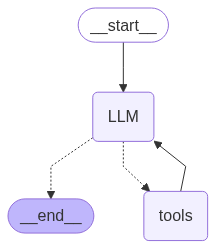

In [11]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

## 6. Testing Our Custom Agent

Now let's test our agent with different types of requests to see how it handles various scenarios. We'll use streaming to see the workflow in action!

In [12]:
# Test 1: Customer Information Request (Requires Tool)
print("🧪 Test 1: Customer Information Request")
print("="*60)
print("User: Can you get information about customer CUST-001?")
print("\nExpected Behavior:")
print("  - LLM processes request")
print("  - Decides to use get_customer_info tool")
print("  - Tool executes and returns customer data")
print("  - LLM provides final response")

# Execute the workflow with streaming to see each step
for chunk in agent.stream(
    {"messages": [("user", "Can you get information about customer CUST-001?")]},
    stream_mode="values"
):
    # Display each step of the workflow
    if "messages" in chunk and chunk["messages"]:
        last_message = chunk["messages"][-1]
        print(f"\n📝 Step Result:")
        print(f"Message Type: {type(last_message).__name__}")
        
        # Check if this is a tool call
        if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
            print(f"🔧 Tool Calls: {len(last_message.tool_calls)}")
            for tool_call in last_message.tool_calls:
                print(f"  - Tool: {tool_call['name']}")
                print(f"  - Args: {tool_call['args']}")
        else:
            print(f"💬 Content: {last_message.content[:200]}...")

print("\n✅ Test 1 Complete!")

# 🤔 What Happened:
#   1. User asked for customer information
#   2. LLM decided to use get_customer_info tool
#   3. Tool executed and returned customer data
#   4. LLM provided final response with the data

🧪 Test 1: Customer Information Request
User: Can you get information about customer CUST-001?

Expected Behavior:
  - LLM processes request
  - Decides to use get_customer_info tool
  - Tool executes and returns customer data
  - LLM provides final response

📝 Step Result:
Message Type: HumanMessage
💬 Content: Can you get information about customer CUST-001?...
🔧 LLM wants to use tools: 1 tool(s) requested

📝 Step Result:
Message Type: AIMessage
🔧 Tool Calls: 1
  - Tool: get_customer_info
  - Args: {'customer_id': 'CUST-001'}

📝 Step Result:
Message Type: ToolMessage
💬 Content: Customer CUST-001: John Smith, Premium tier, total spend: $2,500, last purchase: 2024-01-15...
✅ No tools needed, workflow complete

📝 Step Result:
Message Type: AIMessage
💬 Content: Customer CUST-001 is John Smith, who is in the Premium tier. His total spend is $2,500, and his last purchase was on January 15, 2024....

✅ Test 1 Complete!


In [13]:
# Test 2: Sales Forecast Request (Requires Tool)
print("🧪 Test 2: Sales Forecast Request")
print("="*60)
print("User: What's the Q2 2024 sales forecast for the North region?")
print("\nExpected Behavior:")
print("  - LLM processes request")
print("  - Decides to use get_sales_forecast tool")
print("  - Tool executes and returns forecast data")
print("  - LLM provides final response")
print("\n⌛️ Executing Workflow...")

# Execute the workflow
for chunk in agent.stream(
    {"messages": [("user", "What's the Q2 2024 sales forecast for the North region?")]},
    stream_mode="values"
):
    if "messages" in chunk and chunk["messages"]:
        last_message = chunk["messages"][-1]
        print(f"\n📝 Step Result:")
        print(f"Message Type: {type(last_message).__name__}")
        
        if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
            print(f"🔧 Tool Calls: {len(last_message.tool_calls)}")
            for tool_call in last_message.tool_calls:
                print(f"  - Tool: {tool_call['name']}")
                print(f"  - Args: {tool_call['args']}")
        else:
            print(f"💬 Content: {last_message.content[:200]}...")

print("\n✅ Test 2 Complete!")

# 🤔 What Happened:
#   1. User asked for sales forecast
#   2. LLM decided to use get_sales_forecast tool
#   3. Tool executed with region and period parameters
#   4. LLM provided final response with the forecast data

🧪 Test 2: Sales Forecast Request
User: What's the Q2 2024 sales forecast for the North region?

Expected Behavior:
  - LLM processes request
  - Decides to use get_sales_forecast tool
  - Tool executes and returns forecast data
  - LLM provides final response

⌛️ Executing Workflow...

📝 Step Result:
Message Type: HumanMessage
💬 Content: What's the Q2 2024 sales forecast for the North region?...
🔧 LLM wants to use tools: 1 tool(s) requested

📝 Step Result:
Message Type: AIMessage
🔧 Tool Calls: 1
  - Tool: get_sales_forecast
  - Args: {'region': 'North', 'period': 'Q2 2024'}

📝 Step Result:
Message Type: ToolMessage
💬 Content: Sales forecast for North region in Q2 2024: $1.5M...
✅ No tools needed, workflow complete

📝 Step Result:
Message Type: AIMessage
💬 Content: The sales forecast for the North region in Q2 2024 is $1.5 million....

✅ Test 2 Complete!


In [14]:
# Test 3: Support Ticket Creation (Requires Tool)
print("🧪 Test 3: Support Ticket Creation")
print("="*60)
print("User: Create a high-priority support ticket for CUST-002 because their payment failed")
print("\nExpected Behavior:")
print("  - LLM processes request")
print("  - Decides to use create_support_ticket tool")
print("  - Tool executes and creates ticket")
print("  - LLM provides final response with ticket details")
print("\n⌛️ Executing Workflow...")

# Execute the workflow
for chunk in agent.stream(
    {"messages": [("user", "Create a high-priority support ticket for CUST-002 because their payment failed")]},
    stream_mode="values"
):
    if "messages" in chunk and chunk["messages"]:
        last_message = chunk["messages"][-1]
        print(f"\n📝 Step Result:")
        print(f"Message Type: {type(last_message).__name__}")
        
        if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
            print(f"🔧 Tool Calls: {len(last_message.tool_calls)}")
            for tool_call in last_message.tool_calls:
                print(f"  - Tool: {tool_call['name']}")
                print(f"  - Args: {tool_call['args']}")
        else:
            print(f"💬 Content: {last_message.content[:200]}...")

print("\n✅ Test 3 Complete!")

# 🤔 What Happened:
#   1. User requested support ticket creation
#   2. LLM decided to use create_support_ticket tool
#   3. Tool executed with customer ID, issue, and priority
#   4. LLM provided final response with ticket details

🧪 Test 3: Support Ticket Creation
User: Create a high-priority support ticket for CUST-002 because their payment failed

Expected Behavior:
  - LLM processes request
  - Decides to use create_support_ticket tool
  - Tool executes and creates ticket
  - LLM provides final response with ticket details

⌛️ Executing Workflow...

📝 Step Result:
Message Type: HumanMessage
💬 Content: Create a high-priority support ticket for CUST-002 because their payment failed...
🔧 LLM wants to use tools: 1 tool(s) requested

📝 Step Result:
Message Type: AIMessage
🔧 Tool Calls: 1
  - Tool: create_support_ticket
  - Args: {'customer_id': 'CUST-002', 'issue_description': 'Payment failed', 'priority': 'High'}

📝 Step Result:
Message Type: ToolMessage
💬 Content: Support ticket TKT-CUST-002-040d078c created successfully!
Customer: CUST-002
Issue: Payment failed
Priority: High
Status: Open
Assigned to: Support Team...
✅ No tools needed, workflow complete

📝 Step Result:
Message Type: AIMessage
💬 Content: A high-

In [20]:
# Test 4: General Question (No Tools Needed)
print("🧪 Test 4: General Question (No Tools Required)")
print("="*60)
print("User: What are the benefits of using AI agents in business?")
print("\nExpected Behavior:")
print("  - LLM processes request")
print("  - Decides no tools are needed")
print("  - Provides direct response")
print("  - Workflow ends immediately")
print("\n⌛️ Executing Workflow...")

# Execute the workflow
for chunk in agent.stream(
    {"messages": [("user", "What are the benefits of using AI agents in business?")]},
    stream_mode="values"
):
    if "messages" in chunk and chunk["messages"]:
        last_message = chunk["messages"][-1]
        print(f"\n📝 Step Result:")
        print(f"Message Type: {type(last_message).__name__}")
        print(f"💬 Content: {last_message.content[:200]}...")

print("\n✅ Test 4 Complete!")

# 🤔 What Happened:
#   1. User asked a general business question
#   2. LLM processed the question
#   3. Decided no tools were needed
#   4. Provided direct response and ended workflow

🧪 Test 4: General Question (No Tools Required)
User: What are the benefits of using AI agents in business?

Expected Behavior:
  - LLM processes request
  - Decides no tools are needed
  - Provides direct response
  - Workflow ends immediately

⌛️ Executing Workflow...

📝 Step Result:
Message Type: HumanMessage
💬 Content: What are the benefits of using AI agents in business?...
✅ No tools needed, workflow complete

📝 Step Result:
Message Type: AIMessage
💬 Content: Using AI agents in business offers a variety of benefits, including:

1. **Increased Efficiency**: AI agents can automate repetitive tasks, allowing employees to focus on more strategic activities. Th...

✅ Test 4 Complete!


## 7. Understanding the Workflow in Action

Through our tests, we have observed how the workflow operates in a structured and dynamic manner. The process begins with the user providing input, which is then processed and analyzed by the Language Learning Model (LLM). At this stage, the LLM evaluates the request and determines whether the use of specialized tools is necessary. If tools are required, the workflow seamlessly executes them, after which the LLM processes the results generated by these tools. Finally, the LLM formulates and delivers a comprehensive response to the user, ensuring that the original query is fully addressed.

One of the key insights from this workflow is the clear division of responsibilities: the LLM acts as the "brain" of the system, making all critical decisions and orchestrating the flow, while the tools serve as the "hands," carrying out specific actions as directed. This architecture allows the workflow to remain highly flexible, capable of handling both straightforward and complex requests with ease. Throughout the process, the system maintains state, ensuring that context and information persist across each step. Additionally, the workflow incorporates conditional logic, enabling it to adapt dynamically based on the decisions made by the LLM.

The benefits of this approach are significant. The workflow is inherently scalable, making it straightforward to introduce new tools and expand capabilities as needed. Its maintainable design, with a clear separation of concerns, facilitates ongoing development and troubleshooting. The extensibility of the system allows for the addition of new workflow nodes and logic, supporting evolving business requirements. Finally, the workflow demonstrates reliable and consistent behavior across a wide range of user requests.

For those interested in exploring these concepts further, more information and advanced documentation can be found at: https://python.langchain.com/docs/langgraph/

## 8. Demonstrating the extensibility of the workflow

Let's explore some capabilities that make LangGraph powerful for enterprise applications.

In [21]:
# Let's add a new advanced tool to demonstrate extensibility
@tool
def analyze_customer_trends(customer_id: str, months: int = 6) -> str:
    """
    Analyze customer spending trends over a specified period.
    
    Args:
        customer_id (str): The customer ID to analyze
        months (int): Number of months to analyze (default: 6)
        
    Returns:
        str: Trend analysis and insights
    """
    # Mock trend analysis - in production, this would analyze real transaction data
    import random
    
    # Simulate monthly spending data
    monthly_spending = [random.randint(100, 1000) for _ in range(months)]
    total_spending = sum(monthly_spending)
    average_spending = total_spending / months
    
    # Simple trend analysis
    if monthly_spending[-1] > average_spending:
        trend = "increasing"
    elif monthly_spending[-1] < average_spending:
        trend = "decreasing"
    else:
        trend = "stable"
    
    analysis = f"Customer {customer_id} spending analysis over {months} months:\n"
    analysis += f"Total spending: ${total_spending:,}\n"
    analysis += f"Average monthly spending: ${average_spending:.2f}\n"
    analysis += f"Current trend: {trend}\n"
    analysis += f"Monthly breakdown: {monthly_spending}"
    
    return analysis

print("✅ Tool Created: analyze_customer_trends")

# 🔍 Tool Capabilities:
#   - Analyzes customer spending patterns
#   - Provides trend insights
#   - Generates detailed reports
#   - Demonstrates tool extensibility

✅ Tool Created: analyze_customer_trends


In [22]:
# Now let's create an agent with the new tool
# This demonstrates how easy it is to extend your agent

print("🔄 Creating Agent with New Tool...")

# Add the new tool to our collection
new_tools = [get_customer_info, get_sales_forecast, create_support_ticket, analyze_customer_trends]
new_tool_node = ToolNode(new_tools)
new_llm = llm.bind_tools(new_tools)

# Build workflow
def call_model(state: MessagesState):
    """Model call with additional tools."""
    messages = state["messages"]
    response = new_llm.invoke(messages)
    return {"messages": [response]}

def call_tools(state: MessagesState) -> Literal["tools", END]:
    """Tool routing logic."""
    messages = state["messages"]
    last_message = messages[-1]
    
    if last_message.tool_calls:
        print(f"🔧 Agent using tools: {len(last_message.tool_calls)} tool(s)")
        return "tools"
    
    return END

# Build workflow
new_workflow = StateGraph(MessagesState)
new_workflow.add_node("LLM", call_model)
new_workflow.add_node("tools", new_tool_node)
new_workflow.add_edge(START, "LLM")
new_workflow.add_conditional_edges("LLM", call_tools)
new_workflow.add_edge("tools", "LLM")

new_agent = new_workflow.compile()

print("✅ Agent Created Successfully!")
print(f"Total Tools Available: {len(new_tools)}")
print("\n🧪 Testing Capabilities...")

# Test the new trend analysis capability
print("\nUser: Analyze spending trends for CUST-001 over the last 8 months")

for chunk in new_agent.stream(
    {"messages": [("user", "Analyze spending trends for CUST-001 over the last 8 months")]},
    stream_mode="values"
):
    if "messages" in chunk and chunk["messages"]:
        last_message = chunk["messages"][-1]
        if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
            print(f"\n🧰 Tool Call Detected:")
            for tool_call in last_message.tool_calls:
                print(f"  - Tool: {tool_call['name']}")
                print(f"  - Args: {tool_call['args']}")
        else:
            print(f"\n💬 Final Response: {last_message.content[:300]}...")

print("\n✅ Agent Test Complete!")

# 🔑 Key Takeaway:
#   Adding new tools is simple and doesn't require changing the workflow logic!
#   The agent automatically knows about new capabilities.

🔄 Creating Agent with New Tool...
✅ Agent Created Successfully!
Total Tools Available: 4

🧪 Testing Capabilities...

User: Analyze spending trends for CUST-001 over the last 8 months

💬 Final Response: Analyze spending trends for CUST-001 over the last 8 months...
🔧 Agent using tools: 1 tool(s)

🧰 Tool Call Detected:
  - Tool: analyze_customer_trends
  - Args: {'customer_id': 'CUST-001', 'months': 8}

💬 Final Response: Customer CUST-001 spending analysis over 8 months:
Total spending: $4,272
Average monthly spending: $534.00
Current trend: increasing
Monthly breakdown: [200, 253, 746, 516, 744, 483, 568, 762]...

💬 Final Response: Here's the spending analysis for customer CUST-001 over the last 8 months:

- **Total Spending:** $4,272
- **Average Monthly Spending:** $534.00
- **Current Trend:** Increasing
- **Monthly Breakdown:** 
  - Month 1: $200
  - Month 2: $253
  - Month 3: $746
  - Month 4: $516
  - Month 5: $744
  - Mon...

✅ Agent Test Complete!


## 9. Key Takeaways

### What We've Accomplished

1. **Custom Agent Creation**: Built a fully functional AI agent from scratch
2. **Tool Integration**: Successfully integrated multiple business tools
3. **Workflow Orchestration**: Created intelligent decision-making workflows
4. **State Management**: Implemented proper state flow and context maintenance
5. **Extensibility**: Demonstrated how easy it is to add new capabilities

### Architecture Benefits
#### **Modularity**
- **Separation of Concerns**: LLM handles decisions, tools handle actions
- **Easy Extension**: Add new tools without changing workflow logic
- **Maintainable**: Clear structure makes debugging and updates simple

#### **Intelligence**
- **LLM-Driven Decisions**: Agent intelligently chooses when to use tools
- **Context Awareness**: Maintains understanding across complex requests
- **Adaptive Behavior**: Workflow adapts based on user needs

### Real-World Applications

#### **Customer Service**
- **Automated Support**: Handle common customer inquiries
- **Ticket Management**: Create and track support tickets
- **Customer Insights**: Analyze customer data and trends

#### **Business Intelligence**
- **Sales Analysis**: Generate forecasts and insights
- **Performance Tracking**: Monitor business metrics
- **Reporting**: Automated report generation

#### **Process Automation**
- **Workflow Orchestration**: Coordinate complex business processes
- **Decision Support**: AI-powered business decisions
- **System Integration**: Connect multiple business applications

## 10. Exercise: Build Your Own Agent

Now it's your turn to create a specialized agent for a specific business scenario. Choose one of the following exercises or create your own!

In [23]:
# Exercise 1: Financial Analysis Agent
# Create an agent that can analyze financial data and generate insights

def create_financial_agent():
    """
    TODO: Create a financial analysis agent with the following capabilities:
    
    1. Create a new tool for financial calculations (e.g., ROI, NPV, cash flow)
    2. Add a tool for market data retrieval (e.g., stock prices, market trends)
    3. Build a workflow that can handle financial analysis requests
    4. Test with sample financial scenarios
    
    Example tools to implement:
    - calculate_roi(initial_investment, final_value, time_period)
    - get_market_data(symbol, period)
    - analyze_portfolio_performance(portfolio_data)
    """
    
    # Exercise 1: Financial Analysis Agent
    
    # Create an agent that can:
    #   - Perform financial calculations
    #   - Retrieve market data
    #   - Generate financial insights
    #   - Provide investment recommendations
    
    # TODO: Implement your financial agent here
    
    return "Financial agent implementation goes here"

print("🚀 Ready to build your financial analysis agent!")

🚀 Ready to build your financial analysis agent!


In [ ]:
# Exercise 2: Supply Chain Optimization Agent
# Create an agent that can optimize supply chain operations

def create_supply_chain_agent():
    """
    TODO: Create a supply chain optimization agent with the following capabilities:
    
    1. Create a tool for inventory analysis (e.g., stock levels, reorder points)
    2. Add a tool for demand forecasting (e.g., seasonal trends, growth patterns)
    3. Build a workflow that can handle supply chain optimization requests
    4. Test with sample supply chain scenarios
    
    Example tools to implement:
    - analyze_inventory_levels(product_id, warehouse_id)
    - forecast_demand(product_id, time_period)
    - optimize_reorder_schedule(supplier_data, demand_data)
    """
    
    # Exercise 2: Supply Chain Optimization Agent

    # Create an agent that can:
    #   - Analyze inventory levels
    #   - Forecast demand patterns
    #   - Optimize reorder schedules
    #   - Reduce supply chain costs
    
    # TODO: Implement your supply chain agent here
    
    return "Supply chain agent implementation goes here"

print("🚀 Ready to build your supply chain optimization agent!")

🚀 Ready to build your supply chain optimization agent!


## 11. Next Steps and Advanced Topics

Congratulations! You've successfully built a custom AI agent workflow. Next week we will be covering the following topics:

- Advanced LangGraph Features
- **More about Tools**
-**Multi-Agent Systems**
    - **Agent Coordination**: Multiple agents working together
    - **Specialized Roles**: Different agents for different tasks
    - **Communication Patterns**: Agents sharing information and results

### Additional Resources
**LangGraph Documentation**: [https://langchain-ai.github.io/langgraph/](https://langchain-ai.github.io/langgraph/)

## 12. Conclusion

### What You've Learned

1. **LangGraph Fundamentals**: Understanding the core concepts and architecture
2. **Custom Agent Creation**: Building agents from scratch with full control
3. **Tool Integration**: Basic tool calling
4. **Workflow Orchestration**: Creating intelligent decision-making processes

---

**Happy coding!** 🚀